# Regularizing the N-Body Problem
## Miguel Martinez
## ASTRON 441

The purpose of this notebook is to introduce four different ways of providing more accurate numerical solutions to differential equations. In order, these are

1. Using smaller timesteps

2. Using more efficient integration schemes

3. Using regularization, or transforming into a different set of coordinates

4. Related in this case (but not in general) to the previous, using adaptive timestepping

In this notebook, we take the Kepler problem of a test particle around a central mass as the example problem. Given 

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def Eulerstep(f,u,dt): 
    return u+dt*f(u)

def RK4step(f,u,dt):
    k1 = dt*f(u)
    k2 = dt*f(u+0.5*k1)
    k3 = dt*f(u+0.5*k2)
    k4 = dt*f(u+k3)
    return u + (k1+2*k2+2*k3+k4)/6

integrator_dict = {'Euler': Eulerstep,
                   'RK4': RK4step}

class Orbit(object):
    """
    Simulate a dimensionless orbit of a massless particle arounf a central body with varying eccentricity and demonstrate
    the performance of different integration schemes with and without regularization (coordinate transformations)

    Args:
        e (float): Eccentricity of an elliptical orbit. Must be between 0 and 1
        Integrator (str): Name of integrator to use. Options include 'RK4', 'Euler' (and more to come)
        regularized (bool): If True, uses Kustaanheimo-Steifel (KS) regularization. Otherwise, Cartesian coordinates are used throughout
        dt (float): Timestep to use for integration. When KS regularization is performed, this corresponds to the fictitious time s instead of the physical time t.
    """

    def __init__(self, e=0.99, integrator='Euler', regularized=False, dt=0.1):
        # nondimensionalize the problem by setting all relevant quantities to 1. Can rescale after
        # all equations implicitly assume G=M=1
        self.a = 1

        self.t = 0
        self.nstep = 0
        self.dt = dt
        self.regularized = regularized
        if e>=1 or e<0:
            raise ValueError("Eccentricity must be greater than or equal to 0 and less than 1")
        elif e==0:
            print("Sorry, a couple of the methods here don't play well for (near-)circular orbits, so I'm setting e=1e-5")
            self.e = 1e-5
        else:
            self.e = e
        if integrator in integrator_dict.keys():
            self.integrator = integrator
        else:
            raise Exception("Please provide valid integrator")

        # Initialize orbit at apocenter
        self.f = np.pi

        self.threepos = None
        self.threevel = None

        self.fourpos = None
        self.fourvel = None

        # convert from a,e,f to x,v 3-vectors
        self.convert_kepler2cartesian()
        self.convert_cartesian2regular()
        print("Finished initializing orbit")
    
    # See Murray and Dermott (2000) Ch.2 for these formulae
    def convert_kepler2cartesian(self):
        n = np.power(self.a,-1.5)
        self.threepos = np.array([np.cos(self.f), np.sin(self.f), 0])*self.a*(1-self.e**2) / (1+self.e*np.cos(self.f))
        self.threevel = np.array([np.sin(self.f), self.e+np.cos(self.f), 0])*n*self.a/np.sqrt(1-self.e**2)
    
    def convert_cartesian2kepler(self):
        r = np.linalg.norm(self.threepos)
        v = np.linalg.norm(self.threevel)
        h_vec = np.cross(self.threepos,self.threevel)
        e_vec = np.cross(self.threevel,h_vec) - self.threepos/r
        e = np.linalg.norm(e_vec)
        self.a = 1/(2/r - v**2)
        self.e = e
        f = np.arccos(np.dot(e_vec,self.threepos)/(e*r))
        if np.dot(self.threepos,self.threevel) < 0:
            self.f = 2*np.pi - f
        else:
            self.f = f
    
    def convert_cartesian2regular(self):
        # the transform is non-unique, so I used the version from
        # Appendix A of https://iopscience.iop.org/article/10.1086/429546/pdf
        x,y,z = self.threepos
        r = np.linalg.norm(self.threepos)
        vx,vy,vz = self.threevel

        if x<0:
            u2 = np.sqrt(0.5*(r-x))
            u3 = 0
            u1 = 0.5*y/u2
            u4 = 0.5*z/u2
        else:
            u1 = np.sqrt(0.5*(r+x))
            u4 = 0
            u2 = 0.5*y/u1
            u3 = 0.5*z/u1
        self.fourpos = np.array([u1,u2,u3,u4])

        uv1 = 0.5*(u1*vx + u2*vy + u3*vz)
        uv2 = 0.5*(-u2*vx + u1*vy + u4*vz)
        uv3 = 0.5*(-u3*vx - u4*vy +u1*vz)
        uv4 = 0.5*(u4*vx - u3*vy + u2*vz)
        self.fourvel = np.array([uv1,uv2,uv3,uv4])
    
    def convert_regular2cartesian(self):
        u1,u2,u3,u4 = self.fourpos
        uv1,uv2,uv3,uv4 = self.fourvel
        x = u1**2 - u2**2 - u3**2 + u4**2
        y = 2*(u1*u2 - u3*u4)
        z = 2*(u1*u3 + u2*u4)
        self.threepos = np.array([x,y,z])

        r = np.linalg.norm(self.threepos)
        vx = 2*(u1*uv1 - u2*uv2 - u3*uv3 + u4*uv4)/r
        vy = 2*(u2*uv1 + u1*uv2 - u4*uv3 + u3*uv4)/r
        vz = 2*(u3*uv1 + u4*uv2 + u1*uv3 + u2*uv4)/r

        self.threevel = np.array([vx,vy,vz])

    def get_pos(self):
        return self.threepos
    
    def get_vel(self):
        return self.threevel
    
    def get_time(self):
        return self.t
    
    def get_stepcount(self):
        return self.nstep
    
    def get_kepler(self):
        return self.a, self.e, self.f

    def get_energy(self):
        return 0.5*np.linalg.norm(self.threevel)**2 - 1/np.linalg.norm(self.threepos)

    def dy_normal(self,u):
        # theoretically could be a static method, but must not be if you add in nonunity G and M
        x = u[:3]
        v = u[3:]
        r = np.linalg.norm(x)
        f = -1/r**3
        return np.concatenate((v, f*x), axis=None)
    
    def dy_regular(self,u):
        x = u[:4]
        v = u[4:8]
        #t = u[8]
        h = -self.get_energy()
        r = np.linalg.norm(x)**2
        return np.concatenate((v,-x*h/2,r),axis=None)

    def advance_step(self):
        if self.regularized:
            self.advance_step_regular()
        else:
            self.advance_step_normal()
    
    def advance_step_normal(self):
        y0 = np.concatenate((self.threepos,self.threevel),axis=None)
        stepfunc = integrator_dict[self.integrator]
        y1 = stepfunc(self.dy_normal,y0,self.dt)
        self.t += self.dt
        self.nstep += 1
        self.threepos = y1[:3]
        self.threevel = y1[3:]
        self.convert_cartesian2regular()
        self.convert_cartesian2kepler()
    
    def advance_step_regular(self):
        y0 = np.concatenate((self.fourpos,self.fourvel,self.t),axis=None)
        stepfunc = integrator_dict[self.integrator]
        y1 = stepfunc(self.dy_regular,y0,self.dt)
        self.t = y1[8]
        self.nstep += 1
        self.fourpos = y1[:4]
        self.fourvel = y1[4:8]
        self.convert_regular2cartesian()
        self.convert_cartesian2kepler()



In [26]:
def plot_orbit(e,regularized,integrator,dt,ax1,ax2,label):
    orbit = Orbit(e=e,regularized=regularized,dt=dt,integrator=integrator)
    print(ax1)

    Es = np.nan*np.ones(100000)
    xs = np.nan*np.ones(100000)
    ys = np.nan*np.ones(100000)
    ts = np.nan*np.ones(100000)

    i = 0
    while orbit.get_time()<6.28:
        ts[i] = orbit.get_time()
        xs[i], ys[i],_ = tuple(orbit.get_pos())
        Es[i] = orbit.get_energy()
        orbit.advance_step()
        i+=1
    ax1.scatter(xs,ys,label=label+', nstep='+str(orbit.get_stepcount()),s=2)
    ax2.plot(ts,Es/Es[0])

def init_plot():
    ax[0].set_xlim(-2,2)
    ax[0].set_ylim(-2,2)
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')
    ax[0].set_aspect('equal')
    ax[0].legend()

    ax[1].set_yscale('log')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('E/E0')
    


Finished initializing orbit
AxesSubplot(0.125,0.125;0.352273x0.755)
Finished initializing orbit
AxesSubplot(0.125,0.125;0.352273x0.755)


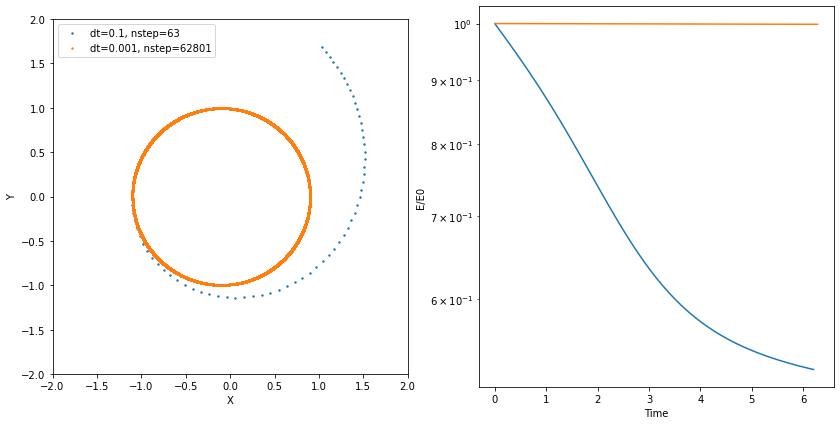

In [27]:
fig, ax = plt.subplots(ncols=2,figsize=(14,7))
plot_orbit(0.1,False,'Euler',0.1,ax[0],ax[1], label='dt=0.1')
plot_orbit(0.1,False,'Euler',0.0001,ax[0],ax[1], label='dt=0.001')
init_plot()

Finished initializing orbit
AxesSubplot(0.125,0.125;0.352273x0.755)
Finished initializing orbit
AxesSubplot(0.125,0.125;0.352273x0.755)


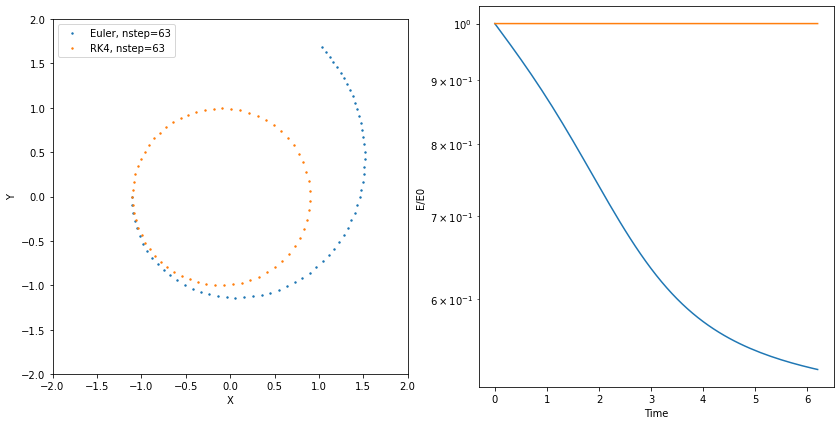

In [28]:
fig, ax = plt.subplots(ncols=2,figsize=(14,7))
plot_orbit(0.1,False,'Euler',0.1,ax[0],ax[1], label='Euler')
plot_orbit(0.1,False,'RK4',0.1,ax[0],ax[1], label='RK4')
init_plot()

Finished initializing orbit
AxesSubplot(0.125,0.125;0.352273x0.755)
Finished initializing orbit
AxesSubplot(0.125,0.125;0.352273x0.755)


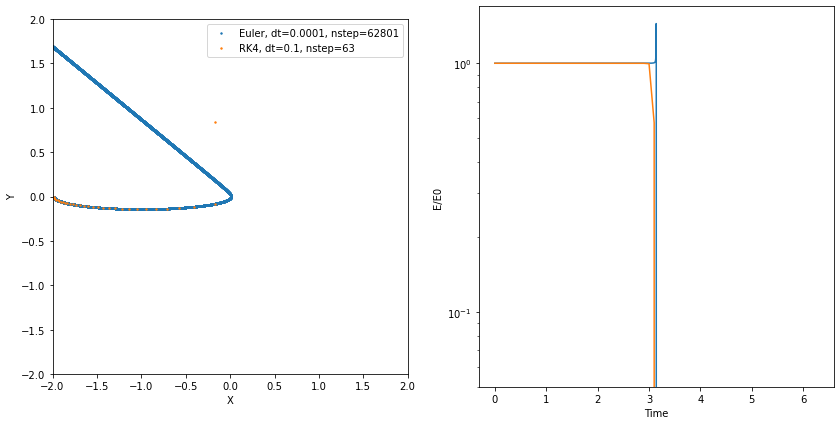

In [29]:
fig, ax = plt.subplots(ncols=2,figsize=(14,7))
plot_orbit(0.99,False,'Euler',0.0001,ax[0],ax[1], label='Euler, dt=0.0001')
plot_orbit(0.99,False,'RK4',0.1,ax[0],ax[1], label='RK4, dt=0.1')
init_plot()

Finished initializing orbit
AxesSubplot(0.125,0.125;0.352273x0.755)
Finished initializing orbit
AxesSubplot(0.125,0.125;0.352273x0.755)


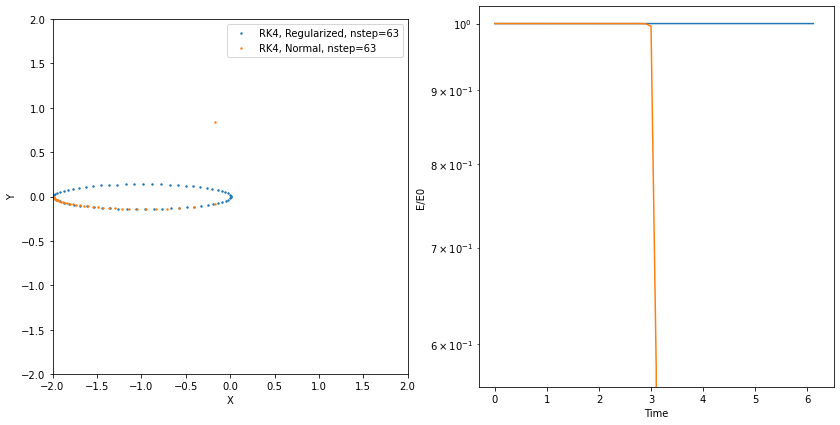

In [30]:
fig, ax = plt.subplots(ncols=2,figsize=(14,7))
plot_orbit(0.99,True,'RK4',0.1,ax[0],ax[1], label='RK4, Regularized')
plot_orbit(0.99,False,'RK4',0.1,ax[0],ax[1], label='RK4, Normal')
init_plot()